In [1]:
import os
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from src.data.plots import *
from src.models.vaelstm import *
from src.train.TrainerVAELSTM import Trainer
from src.data.preprocessing.pipeline import Pipeline
from src.data.datasets.universal_dataset import CVADataset
from src.data.preprocessing.splitter import select_test_inh

In [17]:
prep = Pipeline(
    num_cycle=[1, 2, 3, 4], 
    inhibitor_name="all", 
    split="all",
    norm_feat=True
)

df = prep.full_data

train, val = select_test_inh(df, "benzimidazole")

In [18]:
torch.manual_seed(42)
np.random.seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [19]:
train_dataset = CVADataset(train)
val_dataset = CVADataset(val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE_LSTM(nn.Module):
    def __init__(
        self,
        input_dim: int,
        latent_dim: int,
        hidden_dim: int,
        num_layers: int,
        seq_len: int,
        desc_dim: int,
    ):
        super().__init__()
        self.seq_len    = seq_len
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.input_dim  = input_dim

        # --- Encoder ---
        self.encoder_lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False,
        )
        self.fc_mu     = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # --- Для формирования начального состояния декодера ---
        self.init_h = nn.Linear(latent_dim + desc_dim, num_layers * hidden_dim)

        # --- Decoder ---
        # на вход LSTM мы будем подавать векторы размерности hidden_dim
        self.decoder_lstm = nn.LSTM(
            input_size=input_dim,          # сейчас подаём прошл. выход (input_dim)
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
        )
        self.output_layer = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        # x: (B, seq_len, input_dim)
        _, (h_n, _) = self.encoder_lstm(x)
        h_last = h_n[-1]                # (B, hidden_dim)
        mu     = self.fc_mu(h_last)     # (B, latent_dim)
        logvar = self.fc_logvar(h_last) # (B, latent_dim)
        return mu, logvar

    @staticmethod
    def reparameterize(mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, desc, x=None, teacher_forcing_ratio=1.0):
        """
        В режиме обучения (teacher_forcing_ratio=1.0) мы просто
        подаём в LSTM всю настоящую последовательность x разом,
        и получаем backprop без Python-цикла.
        При inference (ratio=0) можно раскручивать автогенерацию
        с циклом, но во время тренировок он не нужен.
        """
        B = z.size(0)
        # формируем init h0/c0
        h0c0 = self.init_h(torch.cat([z, desc], dim=1))
        h0 = h0c0.view(self.num_layers, B, self.hidden_dim)
        c0 = torch.zeros_like(h0)

        if x is not None and teacher_forcing_ratio > 0.5:
            # Векторизованная часть: сразу весь ground truth
            # x: (B, seq_len, input_dim)
            outputs, _ = self.decoder_lstm(x, (h0, c0))
            return self.output_layer(outputs)

        # Иначе — inference-режим или частичный TF: можно сделать цикл
        # (аналогично тому, что было у вас раньше)
        prev = torch.zeros(B, 1, self.input_dim, device=z.device)
        outputs = []
        h, c = h0, c0
        for t in range(self.seq_len):
            out, (h, c) = self.decoder_lstm(prev, (h, c))
            step = self.output_layer(out)
            outputs.append(step)
            if x is not None and torch.rand(1).item() < teacher_forcing_ratio:
                prev = x[:, t:t+1, :]
            else:
                prev = step
        return torch.cat(outputs, dim=1)

    def forward(self, x, desc, teacher_forcing_ratio=1.0):
        x_in = x.unsqueeze(-1)            # (B, seq_len, 1)
        mu, logvar = self.encode(x_in)
        z          = self.reparameterize(mu, logvar)
        x_recon    = self.decode(z, desc, x_in, teacher_forcing_ratio)
        return x_recon, mu, logvar


def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    # recon_x, x: (B, seq_len, input_dim)
    x = x.unsqueeze(-1)
    recon_loss = F.l1_loss(recon_x, x, reduction='sum')
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kld


In [21]:
model = VAE_LSTM(
    seq_len=968,
    desc_dim=41,
    input_dim=1,
    latent_dim=64,
    hidden_dim=128,
    num_layers=2,
    
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_losses = []
val_losses = []

best_val_loss = float("inf")

for epoch in range(50):
    
    train_true_vah = []
    train_predicted_vah = []
    train_loss = 0.0

    model.train()
    for batch in train_loader:
        vah, desc = batch["vah"].to(device), batch["features"].to(device)
        optimizer.zero_grad()
        vah_hat, m, lv = model(vah, desc)
        loss = vae_loss(vah_hat, vah, m, lv)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # --- здесь правим сбор метрик ---
        vah_np = vah.detach().cpu().numpy()          # (B, seq_len)
        pred_np = vah_hat.detach().cpu().numpy()     # (B, seq_len, 1) или (B, seq_len)
        if pred_np.ndim == 3:
            pred_np = pred_np.squeeze(-1)            # → (B, seq_len)

        # расплющиваем сразу в одномерный список:
    train_true_vah.extend(np.transpose(vah_np[0]))
    train_predicted_vah.extend(np.transpose(pred_np[0]))

    train_loss /= len(train_loader.dataset)
    
    
    val_true_vah = []
    val_predicted_vah = []
    val_loss = 0.0

    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            vah, desc = batch["vah"].to(device), batch["features"].to(device)
            vah_hat, m, lv = model(vah, desc)
            val_loss += vae_loss(vah_hat, vah, m, lv).item()

            vah_np = vah.detach().cpu().numpy()
            pred_np = vah_hat.detach().cpu().numpy()
            if pred_np.ndim == 3:
                pred_np = pred_np.squeeze(-1)

    val_true_vah.extend(np.transpose(vah_np[0]))
    val_predicted_vah.extend(np.transpose(pred_np[0]))

    val_loss /= len(val_loader.dataset)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    
    if epoch % 10 == 0:
    
        plot_models(
            epoch,
            "/home/ccinfochem/Documents/krotkov/Electrochem_DT/reports/vae_lstm/" + f"epoch_{epoch}.png",
            train_true_vah, 
            train_predicted_vah, 
            val_true_vah, 
            val_predicted_vah, 
            train_losses, 
            val_losses
        )
    
        
    print(f"Epoch {epoch:03d} — Train: {train_loss:.4f}, Val: {val_loss:.4f}")

Epoch 000 — Train: 688.0067, Val: 750.7458
Epoch 001 — Train: 506.4787, Val: 348.1732
Epoch 002 — Train: 227.4037, Val: 222.9820
Epoch 003 — Train: 157.7810, Val: 162.1878
Epoch 004 — Train: 110.7958, Val: 104.9296
Epoch 005 — Train: 65.6353, Val: 62.4011
Epoch 006 — Train: 42.9378, Val: 48.0297
Epoch 007 — Train: 35.1833, Val: 40.5493
Epoch 008 — Train: 30.9433, Val: 36.3742
Epoch 009 — Train: 27.6404, Val: 32.9111
Epoch 010 — Train: 25.2417, Val: 30.0041
Epoch 011 — Train: 23.0404, Val: 28.0335
Epoch 012 — Train: 22.2588, Val: 28.3130
Epoch 013 — Train: 20.6523, Val: 25.2807
Epoch 014 — Train: 19.3368, Val: 22.5600
Epoch 015 — Train: 17.6213, Val: 21.5488
Epoch 016 — Train: 16.6660, Val: 19.9655
Epoch 017 — Train: 15.7748, Val: 19.0421
Epoch 018 — Train: 15.0401, Val: 17.9279
Epoch 019 — Train: 14.2020, Val: 16.9819
Epoch 020 — Train: 13.4782, Val: 16.4927
Epoch 021 — Train: 14.1897, Val: 15.6527
Epoch 022 — Train: 13.5062, Val: 17.6709
Epoch 023 — Train: 12.8862, Val: 14.3971
Epoch 

In [7]:
# trainer = Trainer(
#     model=vae,
#     loss_fn=vae_loss,
#     epochs=500,
#     optimizer=opt_vae,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     device=device,
#     path_to_save_plots="/home/ccinfochem/Documents/krotkov/Electrochem_DT/reports/vae_lstm/",
#     path_to_save_models="/home/ccinfochem/Documents/krotkov/Electrochem_DT/models/vae_lstm/best_model.pt",
#     path_to_save_tables="/home/ccinfochem/Documents/krotkov/Electrochem_DT/reports/vae_lstm/",
#     seed=42
# )

In [22]:
from tqdm import tqdm

full_ds = CVADataset(val)
infer_loader = DataLoader(full_ds, batch_size=1, shuffle=False)

vah_preds = []
embeddings = []
model.eval()
with torch.inference_mode():
    for batch in tqdm(infer_loader):
        vah, desc = batch["vah"].to(device), batch["features"].to(device)
        vah_hat, mu, logvar = model(vah, desc)
        embed = model.reparameterize(mu, logvar)
        
        embeddings.append(embed.squeeze().cpu().numpy())
        vah_preds.append(vah_hat.squeeze().cpu().numpy())

# объединяем и превращаем в DataFrame
vah_preds = pd.DataFrame(np.vstack(vah_preds))     # shape [N, 968]
embeddings = pd.DataFrame(np.vstack(embeddings))

100%|██████████| 940/940 [00:08<00:00, 114.16it/s]


In [23]:
embeddings["ppm"] = df["ppm"]
embeddings["Inhibitor"] = df["Inhibitor"]

In [24]:
gen_vah = np.array(vah_preds, dtype=np.float64)
np_val = np.array(val.reset_index(drop=True).drop(columns=prep.desc.columns).drop(columns="ppm"), dtype=np.float64)

In [25]:
from dtaidistance import dtw

def compute_dtw(original, reconstructed):
    """
    Dynamic Time Warping расстояние между временными рядами.
    """
    return dtw.distance_fast(original, reconstructed, use_c = True)

In [26]:
from tqdm import tqdm

dtw_m = []

for i in tqdm(range(len(gen_vah))):
    dtw_m.append(compute_dtw(gen_vah[i], np_val[i]))

100%|██████████| 940/940 [00:03<00:00, 286.24it/s]


In [27]:
metr = pd.DataFrame({
    "Inhibitor": val.reset_index(drop=True)["Inhibitor"],
    "metrics":dtw_m})

In [28]:
metr['metrics'].mean()

0.5414257413066047

In [29]:
metr.to_csv("vae_lstm_benzimidazole.csv", index=False)

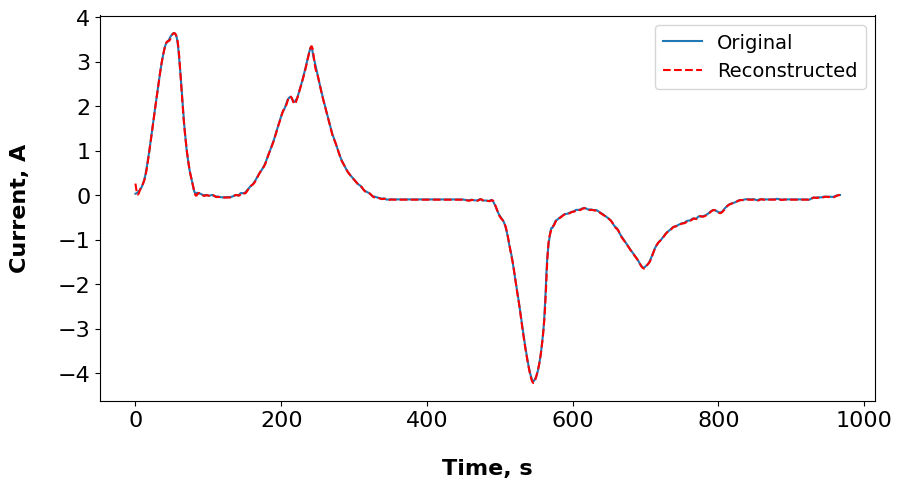

In [76]:
n = 7

plt.figure(figsize=(10, 5))
plt.plot(np_val[n], label="Original")
plt.plot(gen_vah[n], label="Reconstructed", linestyle='--', color='red')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Time, s", fontsize=16, fontweight='bold', labelpad=20)
plt.ylabel("Current, A", fontsize=16, fontweight='bold', labelpad=20)
plt.legend(fontsize=14, )
plt.show()